# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Set Pulse

Text(0.5, 1.0, 'Pulses over time')

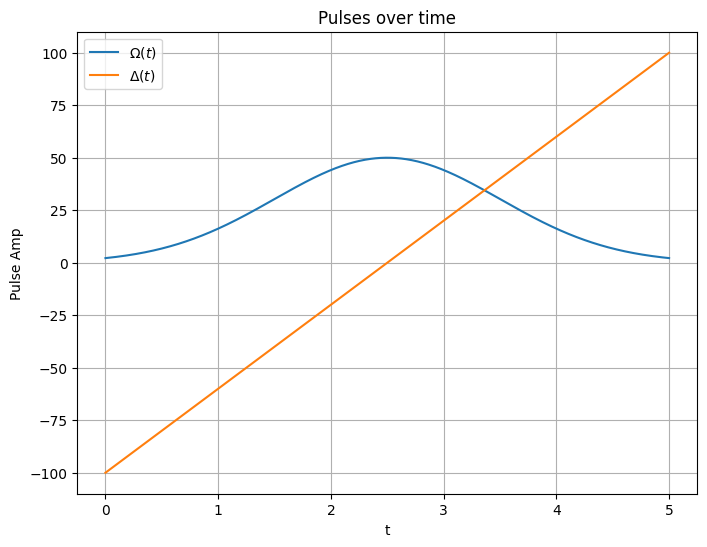

In [50]:
# defining time dependant coefs
T = 5
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'$\Omega(t)$')
plt.plot(t, delta_t, label=r'$\Delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.legend()
plt.title("Pulses over time")


# Defining Stabilizers for 4-qubit code

In [51]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
g1 = tensor(X, X, X, X)
g2 = tensor(Z, Z, Z, Z)
g3 = tensor(X, Y, Z, I)

stabilizers = [
    g1,
    g2,
    g3
]

X_L = tensor(Y, I, Y, I)
Z_L = tensor(Z, Z, I, I)
Y_L = -tensor(I, X, X, I)


In [52]:
basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

logical_one = X_L * logical_zero

# Applying error
# error = tensor(I, X, I, X)
# logical_zero = error * logical_zero
# logical_one = error * logical_one

# Define projection operators
P0 = logical_zero * logical_zero.dag()
P1 = logical_one * logical_one.dag()
P_tot = P0 + P1

-300 0.0 1.0
-300 1.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
-100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
100 0.0 0.0
300 0.0 0.0
300 0.0 0.0
{-300: 2, -100: 6, 100: 6, 300: 2}


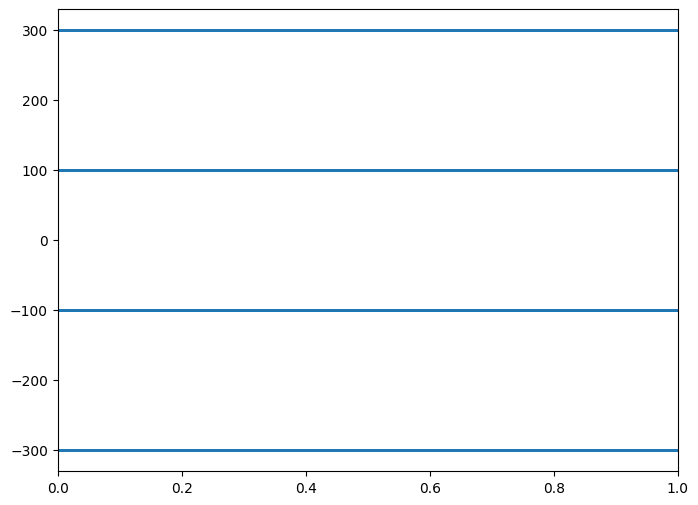

In [57]:
Ep = 100
Hp = -Ep*(g1 + g2 + g3)

eigenvalues, eigenstates = Hp.eigenstates()

energies = {}
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime', 'teal', 'gold', 'navy'
]

plt.figure(figsize=(8, 6))

# Loop through both arrays
for energy, state in zip(eigenvalues, eigenstates):
    
    energy = int(np.round(energy, 1))
    
    if energy not in energies.keys():
        energies[energy] = 1
    else:
        energies[energy] += 1    
    plt.axhline(y = energy, linestyle = '-', linewidth = 2)
    
    proj_zero = np.abs(logical_zero.overlap(state))**2
    proj_one = np.abs(logical_one.overlap(state))**2

    print(energy, np.round(proj_zero), np.round(proj_one))
print(energies)

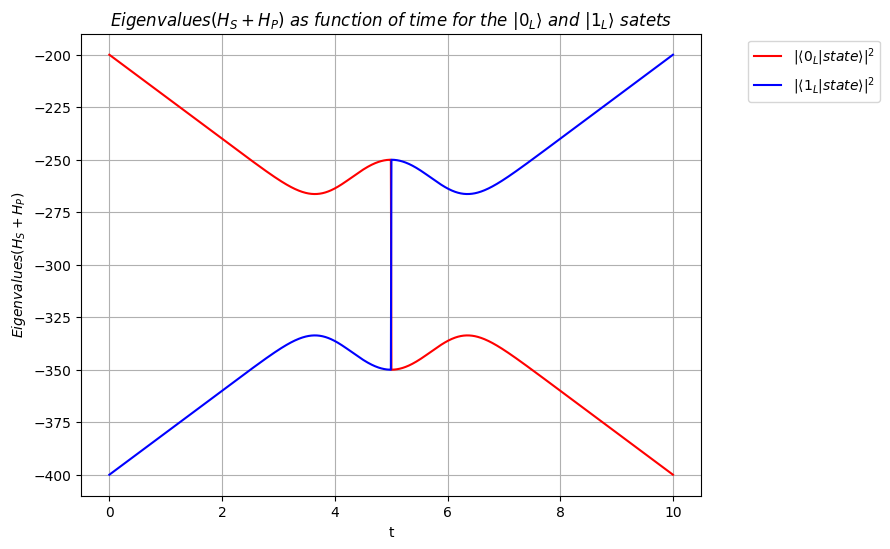

In [185]:
one_eigens = []
zero_eigens = []

for i, t_step in enumerate(t):
    H_S = omega_t[i] * X_L + delta_t[i] * Z_L + Hp
    eigenvalues, eigenstates = H_S.eigenstates()
    
    for energy, state in zip(eigenvalues, eigenstates):        
        proj_zero = np.round(np.abs(logical_zero.overlap(state))**2)
        proj_one = np.round(np.abs(logical_one.overlap(state))**2)
        if proj_zero:
            zero_eigens.append(energy)
        if proj_one:
            one_eigens.append(energy)

plt.figure(figsize=(8, 6))
plt.plot(t, one_eigens, color='r', label =r'$| \langle 0_{L} | state \rangle | ^{2}$')
plt.plot(t, zero_eigens, color='b', label =r'$| \langle 1_{L} | state \rangle | ^{2}$')
plt.xlabel('t')
plt.ylabel(r'$Eigenvalues(H_{S} + H_{P})$')
plt.title(r'$Eigenvalues(H_{S} + H_{P}) \ as \ function \ of \ time \ for \ the \ |0_{L} \rangle \ and \ |1_{L} \rangle \ satets$')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True)

# Ploting the full energy diagram

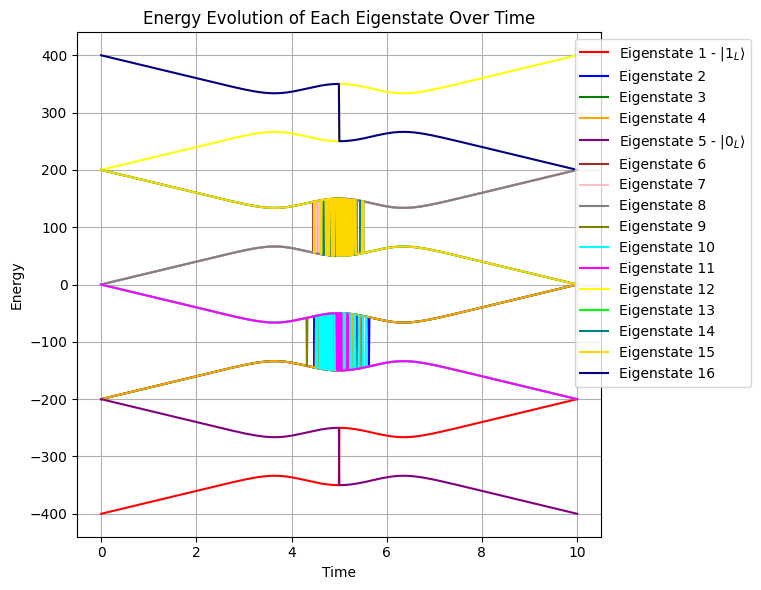

In [186]:
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime', 'teal', 'gold', 'navy'
]


Ep = 100
Hp = -Ep*(g1 + g2 + g3)

T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()

states = {index: [energy] for index, energy in enumerate(eigenvalues_0)}

for t_step in range(1, len(t)):
    H_S = omega_t[t_step] * X_L + delta_t[t_step] * Z_L + Hp
    eigenvalues, eigenstates = H_S.eigenstates()

    for state_index, state_0 in enumerate(eigenstates_0):
        max_overlap = 0
        best_match_index = 0
        
        for i, state_t in enumerate(eigenstates):
            proj = np.abs(state_0.overlap(state_t))**2
            if proj > max_overlap:
                max_overlap = proj
                best_match_index = i

        states[state_index].append(eigenvalues[best_match_index])


plt.figure(figsize=(8, 6))
for state_index, energies in states.items():
    if np.round(np.abs(eigenstates[state_index].overlap(logical_zero))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|0_{L}\rangle$', color=colors[state_index % len(colors)])
    elif np.round(np.abs(eigenstates[state_index].overlap(logical_one))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|1_{L}\rangle$', color=colors[state_index % len(colors)])
    else:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1}', color=colors[state_index % len(colors)])
        
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution of Each Eigenstate Over Time')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.grid()
plt.show()

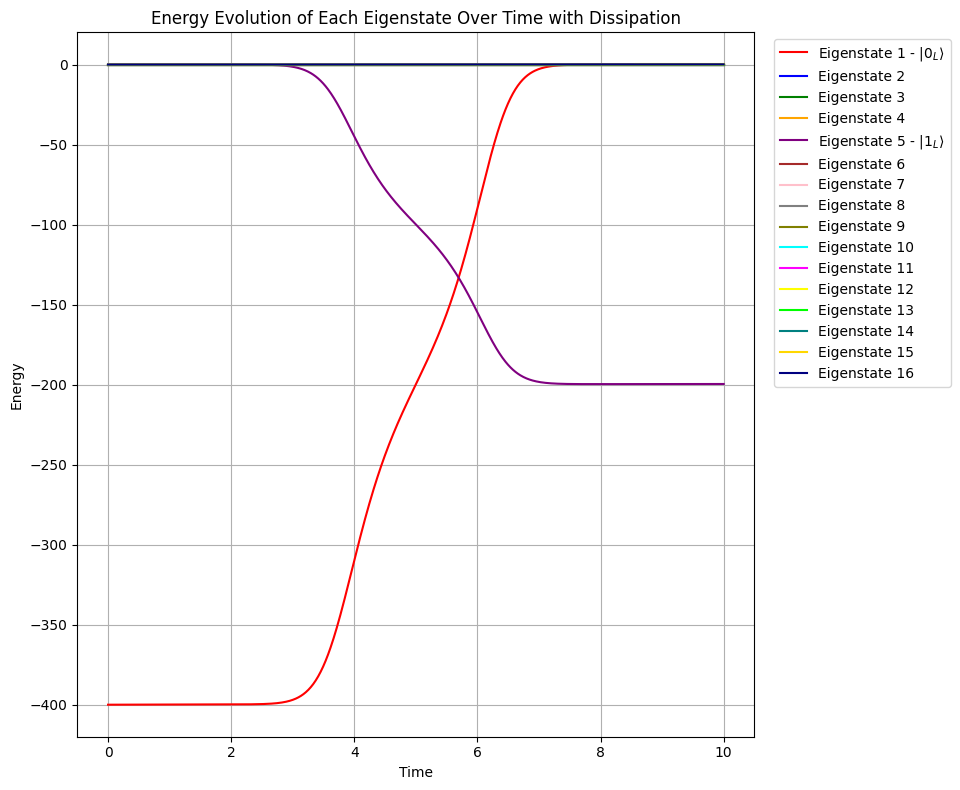

In [187]:
Ep = 100
Hp = -Ep*(g1 + g2 + g3)

T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_max = 50
omega_t = omega_max * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 2*omega_max*(t / (T/2) - 1)

gamma_sqrt = 0.01
C_op = gamma_sqrt * sigmam()

# Collapse operators for the open system
collapse_ops = [
    tensor(C_op, I, I, I),
    tensor(I, C_op, I, I),
    tensor(I, I, C_op, I),
    tensor(I, I, I, C_op)
]

H_S_0 = omega_t[0] * X_L + delta_t[0] * Z_L + Hp
eigenvalues_0, eigenstates_0 = H_S_0.eigenstates()
energy_evolution_open_system = {index: [] for index in range(len(eigenvalues_0))}


H_S = [[X_L, omega_t], [Z_L, delta_t], Hp]
result = mesolve(H_S, logical_zero, t, collapse_ops, [])

# Extract the energy evolution by projecting onto the initial eigenstates
for i, evolved_state in enumerate(result.states):
    for index, eigenstate in enumerate(eigenstates_0):
        # Compute the energy expectation value for the initial eigenstate
        energy = expect(eigenstate.proj(), evolved_state) * eigenvalues_0[index]
        energy_evolution_open_system[index].append(np.real(energy))


plt.figure(figsize=(10, 8))
for state_index, energies in energy_evolution_open_system.items():
    if np.round(np.abs(eigenstates_0[state_index].overlap(logical_zero))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|0_{L}\rangle$', color=colors[state_index % len(colors)])
    elif np.round(np.abs(eigenstates_0[state_index].overlap(logical_one))**2) == 1:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1} - ' + r'$|1_{L}\rangle$', color=colors[state_index % len(colors)])
    else:
        plt.plot(t, energies, label=f'Eigenstate {state_index+1}', color=colors[state_index % len(colors)])

plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution of Each Eigenstate Over Time with Dissipation')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.grid()
plt.show()
